# Benji, Wendi, Yiwen

Dataset can be downloaded at:

https://www.kaggle.com/zynicide/wine-reviews

In [1]:
library(readr)
library(dplyr)
library(tidyr)
library(ggplot2)
library(gbm)
library(gam)
library(stringr)


Attaching package: ‘dplyr’

The following objects are masked from ‘package:stats’:

    filter, lag

The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union

Loaded gbm 2.1.4
Loading required package: splines
Loading required package: foreach
Loaded gam 1.16



Read in the data, drop duplicates, drop `description`, `winery`, and `taster_twitter_handle`.

In [2]:
read_csv("Data/wine-reviews/winemag-data-130k-v2.csv") %>% select(-X1) %>% unique %>% 
select(-description, -winery, -taster_twitter_handle) -> data

Warning message:
“Missing column names filled in: 'X1' [1]”Parsed with column specification:
cols(
  X1 = col_integer(),
  country = col_character(),
  description = col_character(),
  designation = col_character(),
  points = col_integer(),
  price = col_double(),
  province = col_character(),
  region_1 = col_character(),
  region_2 = col_character(),
  taster_name = col_character(),
  taster_twitter_handle = col_character(),
  title = col_character(),
  variety = col_character(),
  winery = col_character()
)


In this notebook, we will attempt to automate some of the data munging/imputation. 

We want to scale `points` by the taster, since the distribution of points is likely dependent on the taster. Therefore, we will attempt two different methods of unifying this distribution: scaling by standardization and scaling by percentile of score.

In [3]:
scale_taster <- function(points){
    # takes a vector of numbers, subtracts every element by the mean of the vector, and then
    # divides every element by the standard deviation of the vector
    
    return((points - mean(points, na.rm = TRUE)) / sd(points, na.rm = TRUE))
}

In [4]:
percentile_taster <- function(x){
    # takes a vector of numbers, ranks every element and divides by n, giving the percentile of each element
    trunc(rank(x))/length(x) * 100
}

In [5]:
data <- data %>% group_by(taster_name) %>% mutate("Scaled_Points" = scale_taster(points))

In [6]:
data <- data %>% group_by(taster_name) %>% mutate("Percentile_Points" = percentile_taster(points))

We want to reduce the number of provinces. If a given province only appears less than 1% of the time, we want to change that province to its country instead. However, we want to distinguish these miscellaneous provinces from the major ones, so we will call it `country_other`.

In [7]:
tab <- data %>% group_by(province) %>% summarize("Proportion" = n()/nrow(data))
tab <- tab[tab$Proportion > 0.01, ]

tabcountry <-  data %>% group_by(country) %>% summarize("Proportion" = n()/nrow(data))
tabcountry <- tabcountry[tabcountry$Proportion > 0.01, ]

In [8]:
data$country_other <- ifelse(data$country %in% tabcountry$country, 
                                paste0(data$country, "_other"), data$country)
data$location <- ifelse(data$province %in% tab$province, data$province,
                                     data$country_other)

Now that we have consolidated provinces under the `location` variable, we can drop `province` and `country_other` since we no longer have any need for them.

In [9]:
data <- data %>% select(-province, -country_other)

We can extract the year that the wine was produced from its title:

In [10]:
year <- str_extract_all(data$title, "[0-9]{4}")

In [11]:
data$year <- lapply(year, function(x){
    x = x %>% as.numeric
    if(!all(is.na(x))){
        newx <- x[(x > 1900) & (x < 2018)]
        if(!all(is.na(newx))){
            newx <- max(newx)
            return(newx)
        }
        else{
            return(NA)
        }
    }
    else {
        return(NA) 
    }}) %>% unlist

Drop `region_1`, `region_2`, and `designation` due to too many unique values. Also drop title and country since we no longer need them.

In [12]:
data <- data %>% select(-region_1, -region_2, -designation, -title, -country)

Impute "Missing" category for the observations with `taster_name = NA`

In [13]:
data[which(is.na(data$taster_name)), ]$taster_name <- "Missing"

We want to impute `price` by the average price of the missing wine's variety, i.e. we will group by variety, take the mean, and then use that value to impute. However, we won't be able to impute the price of wines where the variety has only missing prices because then the mean wouldn't be defined. Thus, these cases will be removed.

In [14]:
impute_mean <- function(x) replace(x, is.na(x), mean(x, na.rm = TRUE))
    # impute_mean replaces missing values with the average value of a group

In [15]:
clean <- function(df){
    # clean removes the varieties that only have missing prices, and are thus unimputable by our rule,
    # and then it imputes the remaining missing prices using the average price of that wine's variety
    
    df %>% group_by(variety) %>% summarize("Average_Price" = mean(price, na.rm = T), 
                                           "Count" = n()) %>% 
    filter(is.na(Average_Price)) %>% select(variety) %>% unlist() -> drop_variety 
    
    df %>% filter(!(variety %in% drop_variety)) -> df
    
    df %>% group_by(variety) %>% mutate(price = impute_mean(price))
}

In [16]:
change_to_factor <- function(df){

    df$location <- factor(df$location)
    df$taster_name <- factor(df$taster_name)
    df$variety <- factor(df$variety)
    return(df)
}

In [17]:
data <- change_to_factor(data)

We must change our categorical variables to factors for our functions to handle them correctly.

# Gradient-Boosted Machine

K-Fold Cross-Validation:

Warning message in split.default(c(1:nrow(data)), c(1:k)):
“data length is not a multiple of split variable”

[1] 1


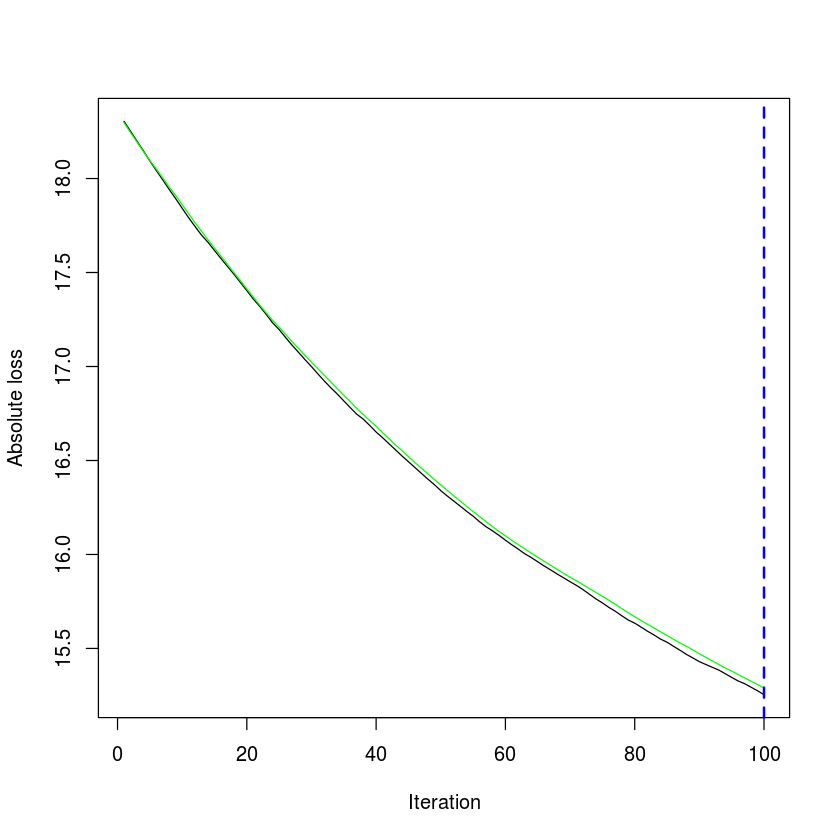

[1] 2


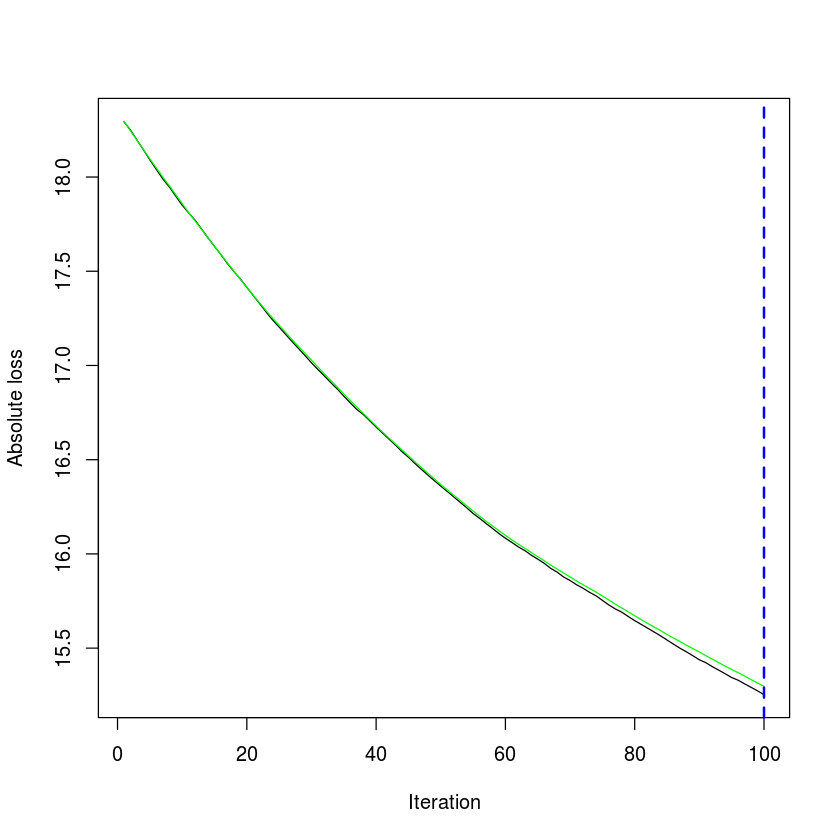

[1] 3


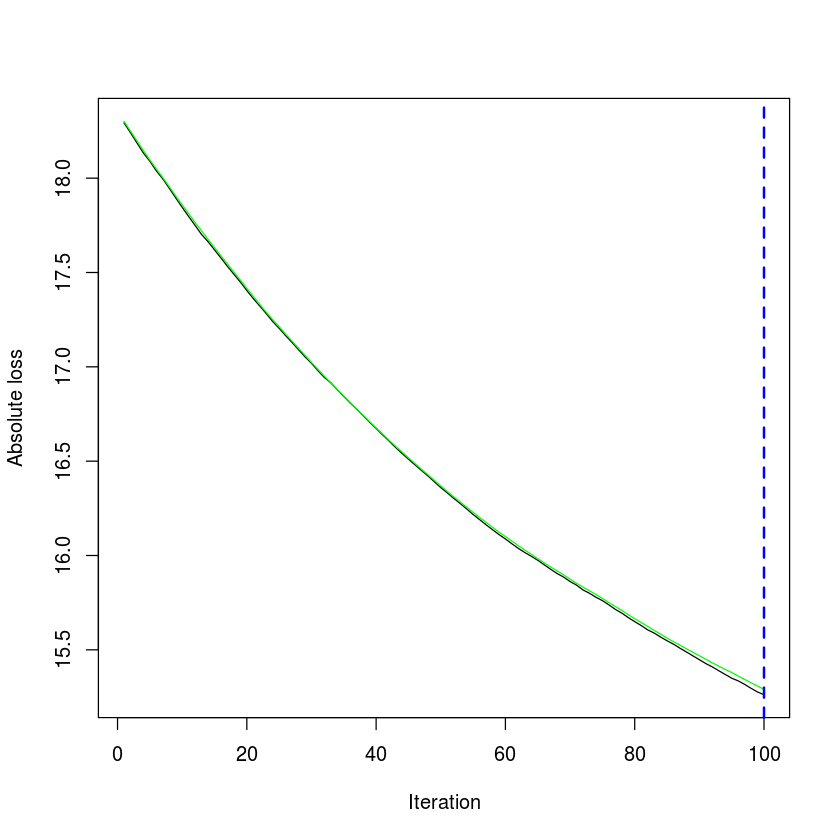

[1] 4


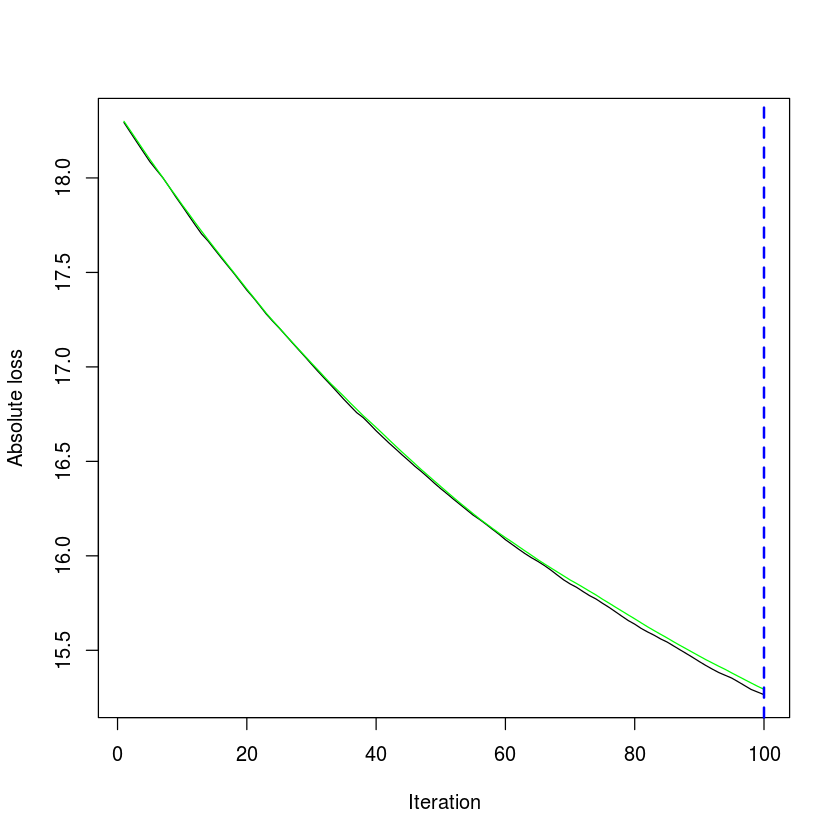

[1] 5


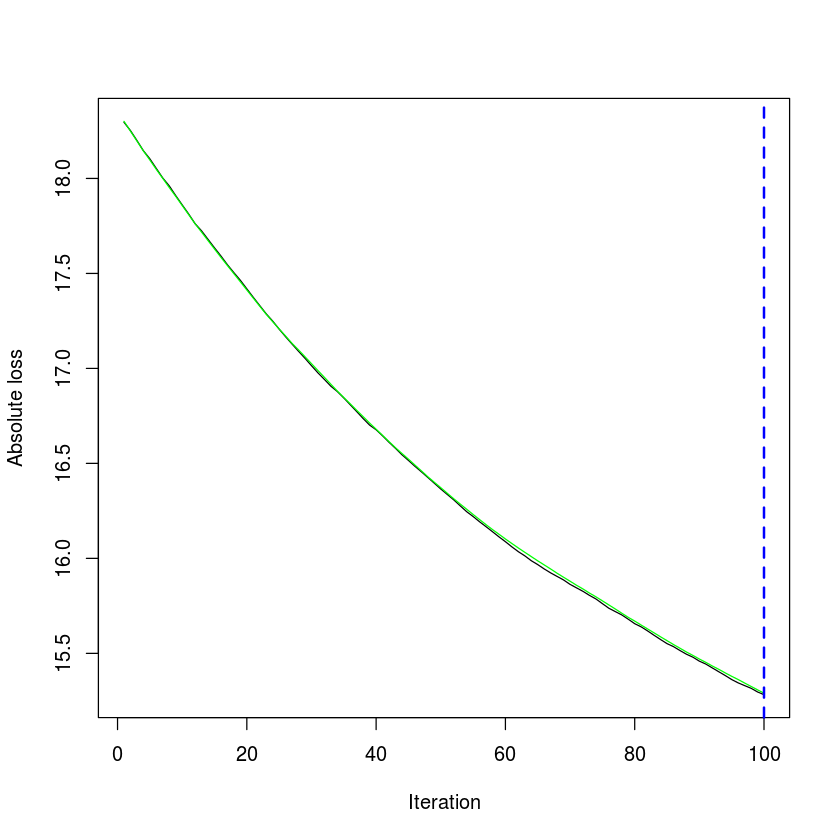

[1] 6


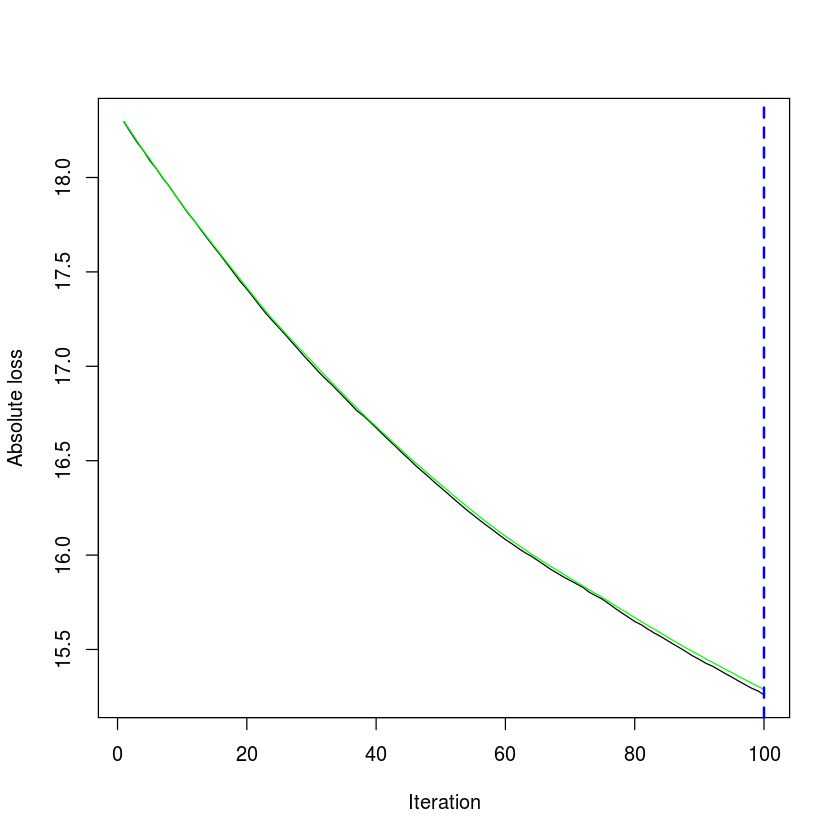

[1] 7


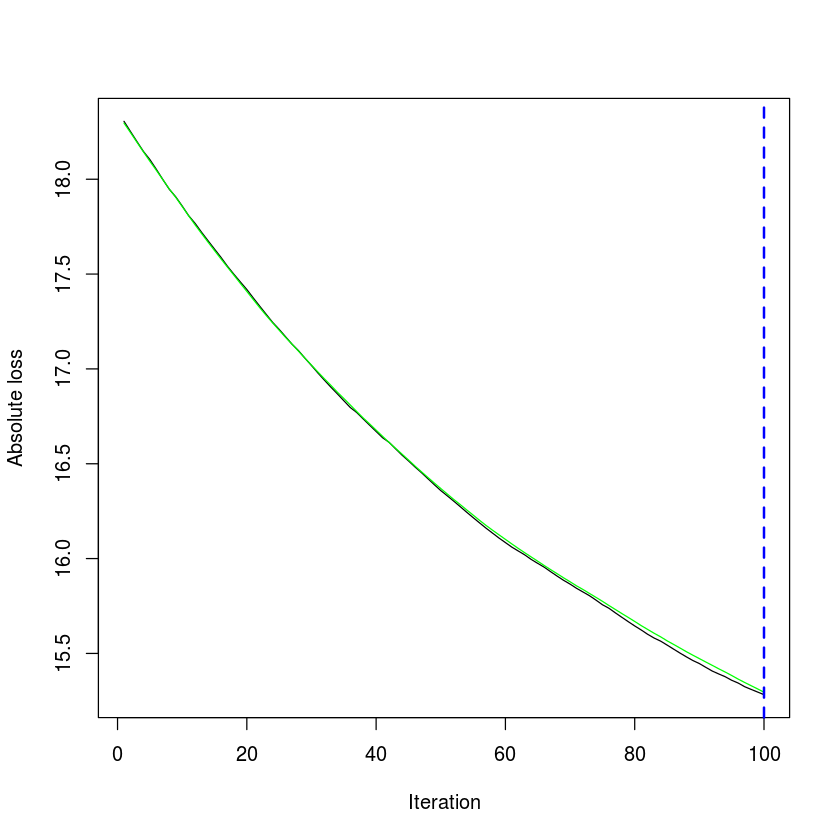

[1] 8


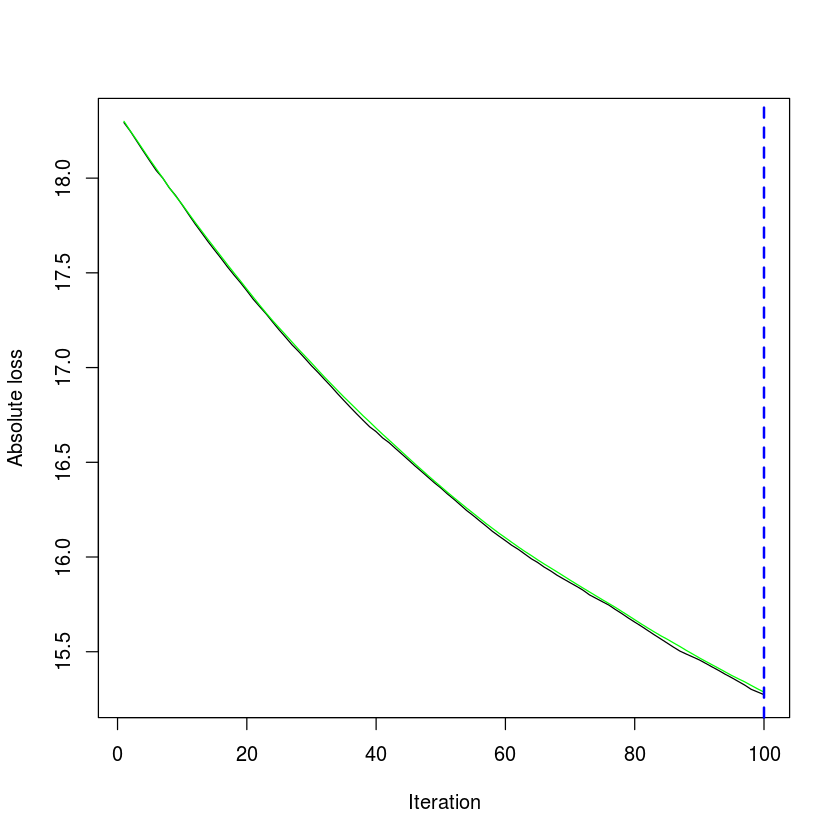

[1] 9


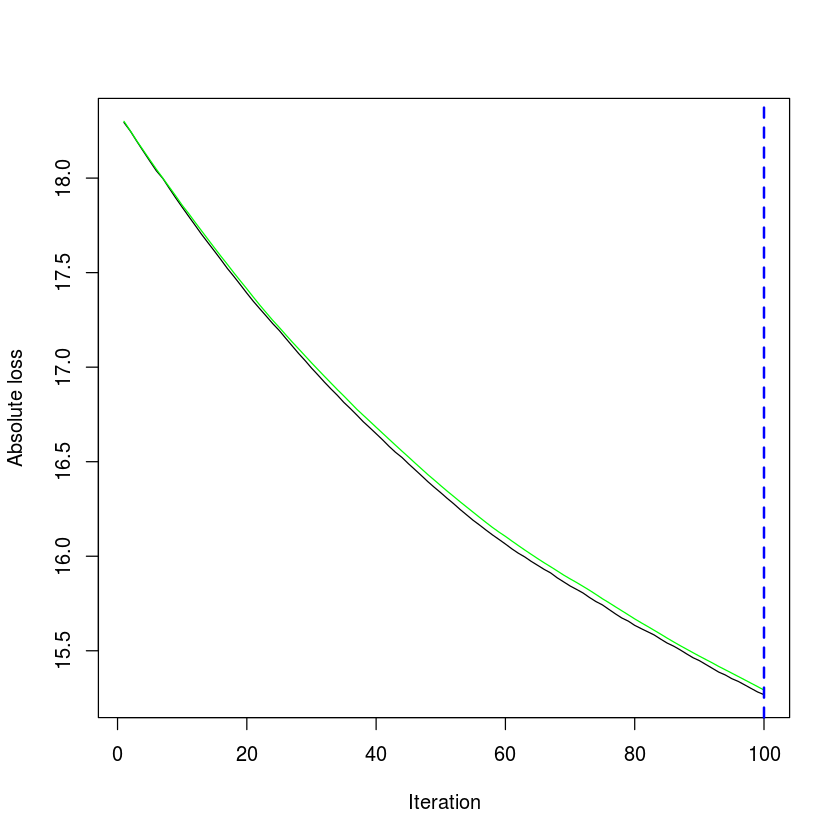

[1] 10


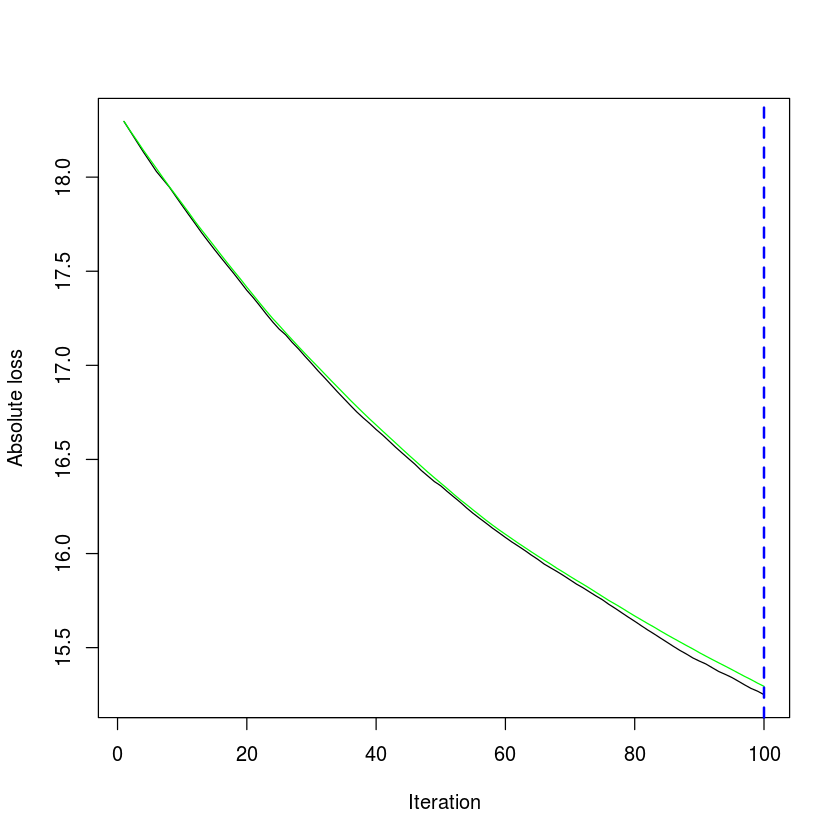

In [26]:
set.seed(2018)
k <- 10
sp <- split(c(1:nrow(data)), c(1:k))
fold_error <- c()
sample <- data %>% select(-points, -Scaled_Points)

for(i in 1:k){
    # First we impute the missing prices
    train <- clean(sample[-sp[[k]], ])
    test <- clean(sample[sp[[k]], ])
    
    # Take note of the formula here, price ~ taster_name + variety + Percentile_Points + location + year
    gbmFit <- gbm(formula = price ~ taster_name + variety + Percentile_Points + location + year, data = train, 
                  n.trees = 100, shrinkage = 0.01, interaction.depth = 2, cv.folds = 10, 
                  distribution = "laplace")

    best_iter <- gbm.perf(gbmFit, method = "cv")
    
    abs_error <- abs(test$price - predict(gbmFit, newdata = test, n.trees = best_iter))
    fold_error <- c(fold_error, mean(abs_error, na.rm = TRUE))
}

In [27]:
error_df <- data.frame("KFold" = 1:k, "MAE" = fold_error)
fold <- which(error_df$MAE == min(error_df$MAE))
paste0("We will use fold #", fold, " to train our model.")

[1] "We will use fold #1 to train our model."

Now we will assess our model on the full data set.

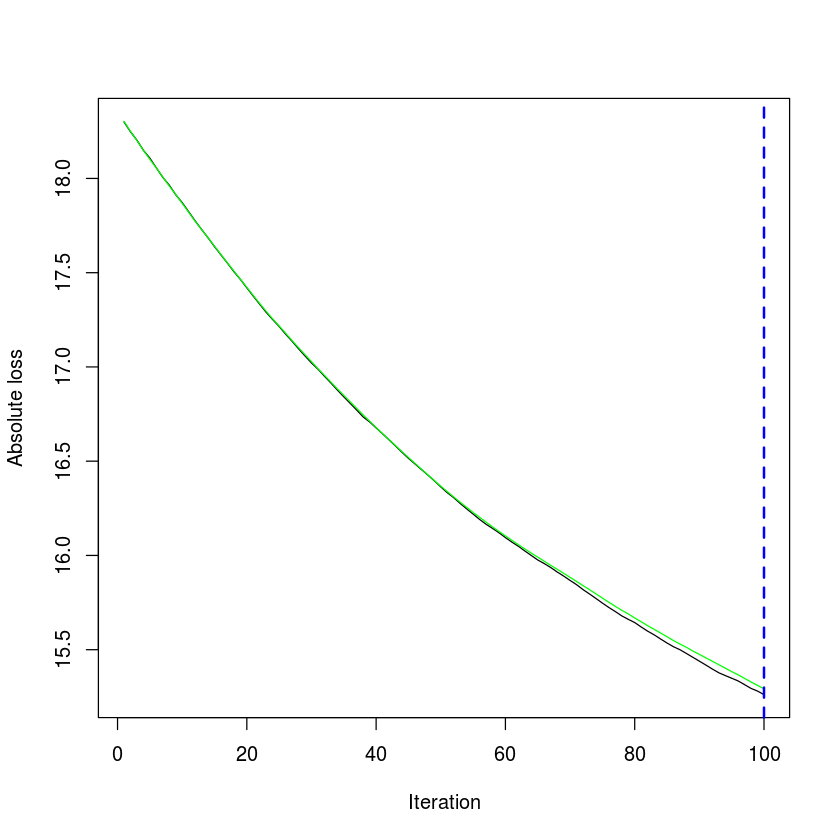

In [28]:
train <- clean(sample[-sp[[1]], ])
    
gbmFit <- gbm(formula = price ~ taster_name + variety + Percentile_Points + location + year, data = train,
              n.trees = 100, shrinkage = 0.01, interaction.depth = 2, cv.folds = 10,
              distribution = "laplace")

best_iter <- gbm.perf(gbmFit, method = "cv")
    
abs_error <- abs(data$price - predict(gbmFit, newdata = data, n.trees = best_iter))

In [29]:
print(mean(abs_error, na.rm = TRUE)) # our performance on the test data

[1] 15.60807


# XGBoost

In [30]:
library(xgboost)


Attaching package: ‘xgboost’

The following object is masked from ‘package:dplyr’:

    slice



Working on it...